#### Student Number A00279668

### Load the libraries

In [1]:
import os
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

### Import the dataset

In [2]:
# import the dataset
df = pd.read_excel('preparedData.xlsx')

In [3]:
df.head()

,date,new_cases_smoothed,reproduction_rate,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,...,book covid test: (Ireland)_y,covid test dublin: (Ireland),covid test centre: (Ireland),hse covid vaccine: (Ireland),hse vaccine portal: (Ireland),hse portal vaccine: (Ireland),pcr test hse: (Ireland),hse covid test: (Ireland),hse vaccine registration: (Ireland),how long will it take to vaccinate ireland: (Ireland)
0,2020-03-15,15.714,2.51,0,0.0,0.0,0,0,0,0,...,0,1,2,0,0,0,0,2,0,0
1,2020-03-16,21.143,2.59,0,0.0,0.0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
2,2020-03-17,27.000,2.70,0,0.0,0.0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
3,2020-03-18,35.571,2.78,0,0.0,0.0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
4,2020-03-19,73.429,2.84,946,0.0,0.0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [4]:
df.shape

(699, 50)

In [5]:
date_time = pd.to_datetime(df.pop('date'), format='%d-%m-%Y')

In [6]:
df.columns

Index(['new_cases_smoothed', 'reproduction_rate', 'new_tests', 'positive_rate',
       'tests_per_case', 'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'total_boosters', 'new_vaccinations',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'life_expectancy', 'human_development_index',
       'covid: (Ireland)', 'COVID-19 testing: (Ireland)',
       'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and management of COVID-19

In [7]:
df.drop(columns=['population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'life_expectancy', 'human_development_index',
       'Vaccination: (Ireland)','total_boosters','COVID-19 rapid antigen test: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'book covid test: (Ireland)_y', 'covid test dublin: (Ireland)',
       'covid test centre: (Ireland)', 'hse covid vaccine: (Ireland)',
       'hse vaccine portal: (Ireland)', 'hse portal vaccine: (Ireland)',
       'pcr test hse: (Ireland)', 'hse covid test: (Ireland)',
       'hse vaccine registration: (Ireland)',
       'how long will it take to vaccinate ireland: (Ireland)'], inplace=True)

In [8]:
#df.describe().transpose()

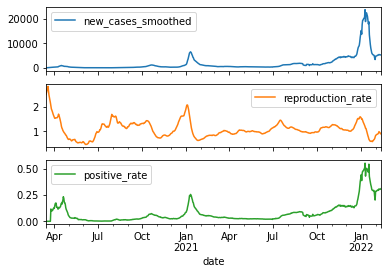

In [9]:
plot_cols = ['new_cases_smoothed', 'reproduction_rate', 'positive_rate']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

#plot_features = df[plot_cols][:700]
#plot_features.index = date_time[:700]
#_ = plot_features.plot(subplots=True)
#

In [10]:
#Split the data 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
test_df.drop(test_df.tail(2).index,inplace = True)

In [13]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# class WindowGenerator():
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [14]:
w1 = WindowGenerator(input_width=14, label_width=1, shift=1,
                     label_columns=['new_cases_smoothed'])
w1

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['new_cases_smoothed']

In [15]:
w2 = WindowGenerator(input_width=21, label_width=3, shift=1,
                     label_columns=['new_cases_smoothed'])
w2

Total window size: 22
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [19 20 21]
Label column name(s): ['new_cases_smoothed']

In [16]:
#https://www.tensorflow.org/tutorials/structured_data/time_series 
# GOT UPTO DATA WINDOWING

In [17]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 22, 14)
Inputs shape: (3, 21, 14)
Labels shape: (3, 3, 1)


In [19]:
w2.example = example_inputs, example_labels

In [20]:
def plot(self, model=None, plot_col='new_cases_smoothed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('new_cases_smoothed')

WindowGenerator.plot = plot


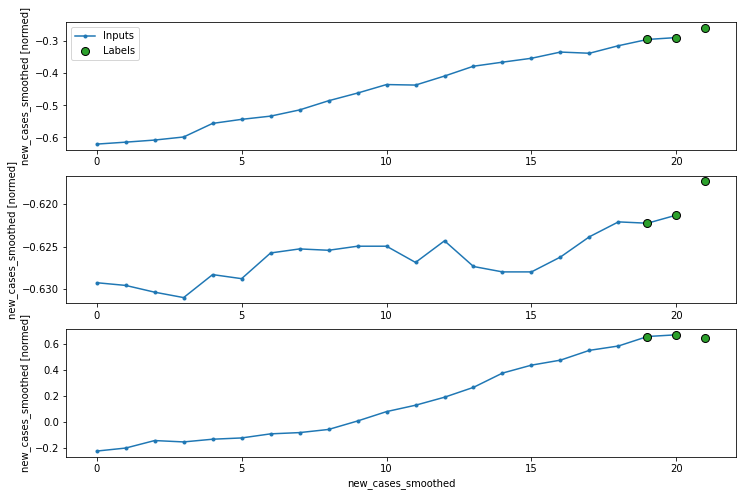

In [21]:
w2.plot()

In [22]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [23]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [24]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 21, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None))

In [25]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 21, 14)
Labels shape (batch, time, features): (32, 3, 1)


In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['new_cases_smoothed'])
single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['new_cases_smoothed']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [29]:
baseline = Baseline(label_index=column_indices['new_cases_smoothed'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


5/5 [==============================] - 0s 3ms/step - loss: 0.0181 - mean_absolute_error: 0.0846


In [30]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=['new_cases_smoothed'])

wide_window


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['new_cases_smoothed']

In [31]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 7, 14)
Output shape: (32, 7, 1)


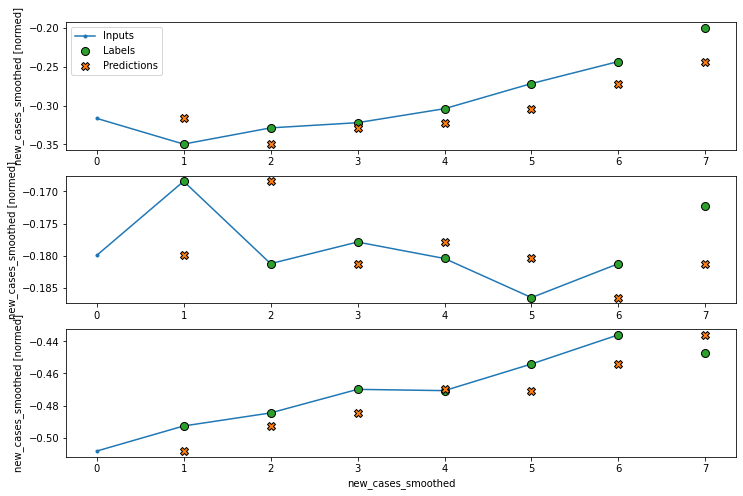

In [32]:
#Baseline
wide_window.plot(baseline)


In [33]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/50
16/16 [==============================] - 1s 20ms/step - loss: 0.9167 - mean_absolute_error: 0.5678 - val_loss: 5.9693 - val_mean_absolute_error: 2.2330
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.3911 - mean_absolute_error: 0.3017 - val_loss: 4.4110 - val_mean_absolute_error: 1.9201
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1665 - mean_absolute_error: 0.2027 - val_loss: 3.8588 - val_mean_absolute_error: 1.8117
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0518 - mean_absolute_error: 0.1387 - val_loss: 3.1706 - val_mean_absolute_error: 1.6167
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0229 - mean_absolute_error: 0.1051 - val_loss: 2.9033 - val_mean_absolute_error: 1.5274
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0161 - mean_absolute_error: 0.0869 - val_loss: 3.1978 - val_mean_absolute_error: 1.6154
Epoch 7/50
16/16 [====

In [35]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['new_cases_smoothed'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['new_cases_smoothed']

Text(0.5, 1.0, 'Given 21 days of inputs, predict 3 day into the future.')

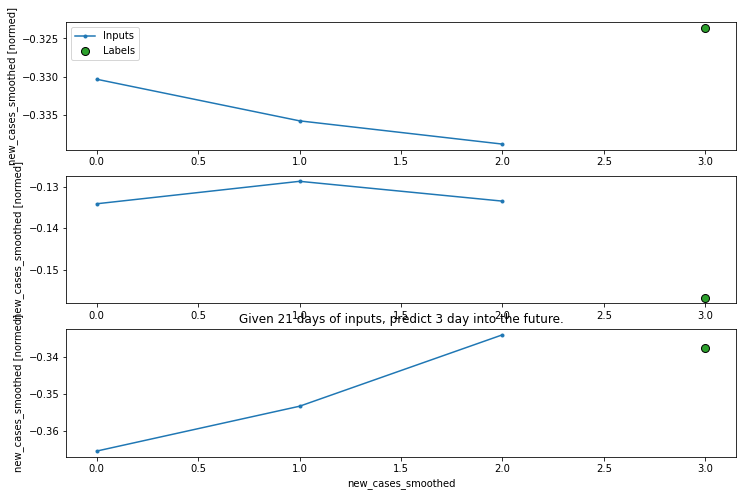

In [36]:
conv_window.plot()
plt.title("Given 21 days of inputs, predict 3 day into the future.")


In [37]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [38]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [39]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


5/5 [==============================] - 0s 3ms/step - loss: 0.7609 - mean_absolute_error: 0.6774


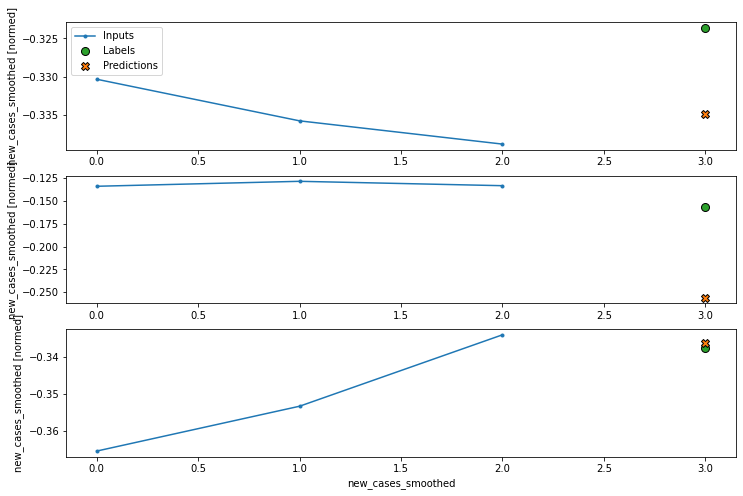

In [40]:
conv_window.plot(multi_step_dense)



In [41]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')


Input shape: (32, 7, 14)

ValueError:Exception encountered when calling layer "sequential_1" (type Sequential).

Input 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 42, but received input with shape (32, 98)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 7, 14), dtype=float32)
  • training=None
  • mask=None


In [42]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [43]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [44]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


5/5 [==============================] - 0s 5ms/step - loss: 1.0942 - mean_absolute_error: 0.8782


In [45]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 7, 14)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [46]:
LABEL_WIDTH = 14
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['new_cases_smoothed'])

wide_conv_window


Total window size: 17
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Label column name(s): ['new_cases_smoothed']

In [47]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 16, 14)
Labels shape: (32, 14, 1)
Output shape: (32, 14, 1)


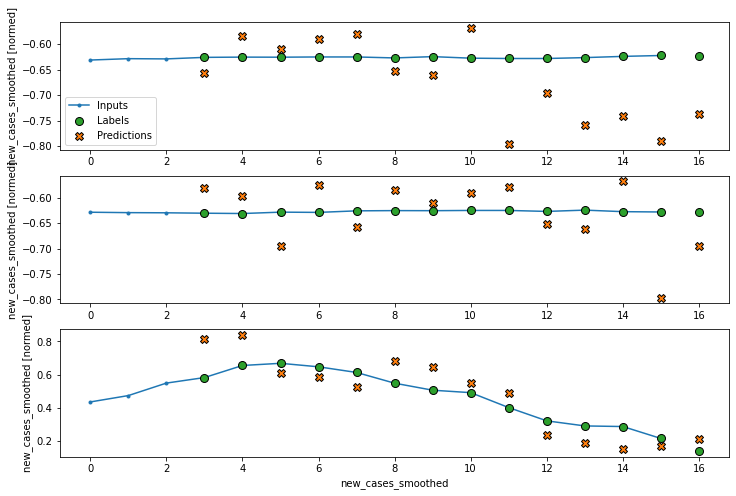

In [48]:
wide_conv_window.plot(conv_model)


In [49]:
# recurrent neural network

In [50]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 7, 14)
Output shape: (32, 7, 1)


In [52]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


5/5 [==============================] - 0s 5ms/step - loss: 1.5062 - mean_absolute_error: 0.9638


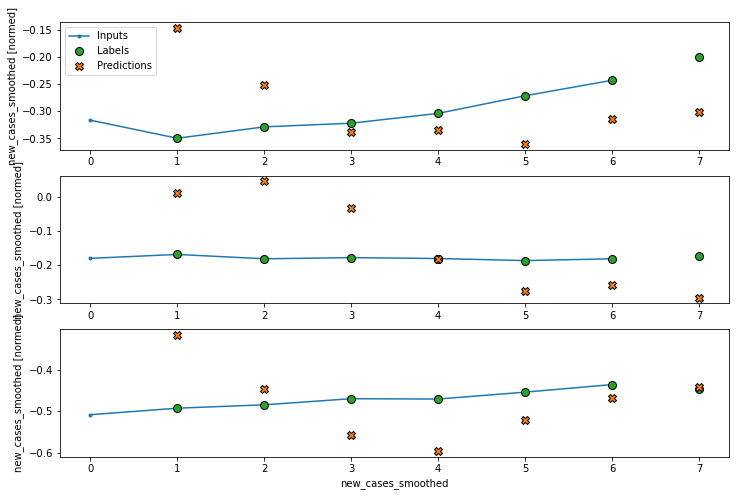

In [53]:

wide_window.plot(lstm_model)


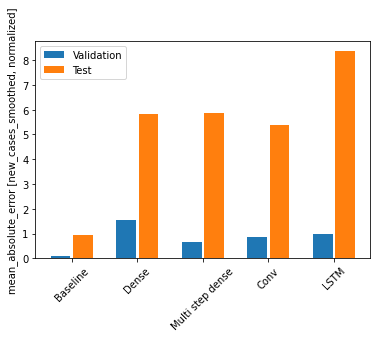

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [new_cases_smoothed, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [55]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.9292
Dense       : 5.8221
Multi step dense: 5.8655
Conv        : 5.3933
LSTM        : 8.3619


In [56]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 14)


In [57]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


In [58]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


4/4 [==============================] - 0s 5ms/step - loss: 0.1803 - mean_absolute_error: 0.0997


In [59]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])


In [60]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


5/5 [==============================] - 0s 6ms/step - loss: 0.9620 - mean_absolute_error: 0.7446


In [61]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()


4/4 [==============================] - 0s 7ms/step - loss: 2.3641 - mean_absolute_error: 1.1772

CPU times: user 13.8 s, sys: 4.97 s, total: 18.7 s
Wall time: 14.3 s


In [62]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta


In [63]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()


4/4 [==============================] - 0s 7ms/step - loss: 0.1889 - mean_absolute_error: 0.1314

CPU times: user 1.88 s, sys: 390 ms, total: 2.27 s
Wall time: 1.94 s


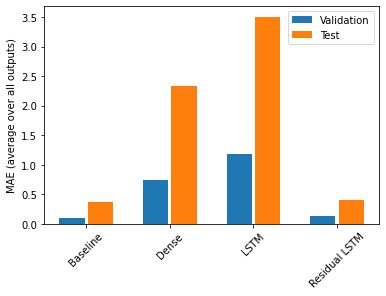

In [64]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [65]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')


Baseline       : 0.3697
Dense          : 2.3314
LSTM           : 3.5039
Residual LSTM  : 0.3989


Total window size: 10
Input indices: [0 1 2 3 4]
Label indices: [5 6 7 8 9]
Label column name(s): None

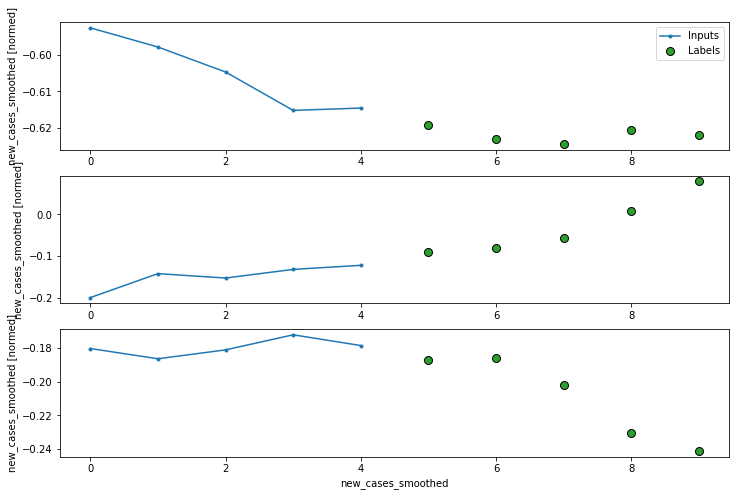

In [66]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=5,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window


5/5 [==============================] - 0s 5ms/step - loss: 0.2573 - mean_absolute_error: 0.1880


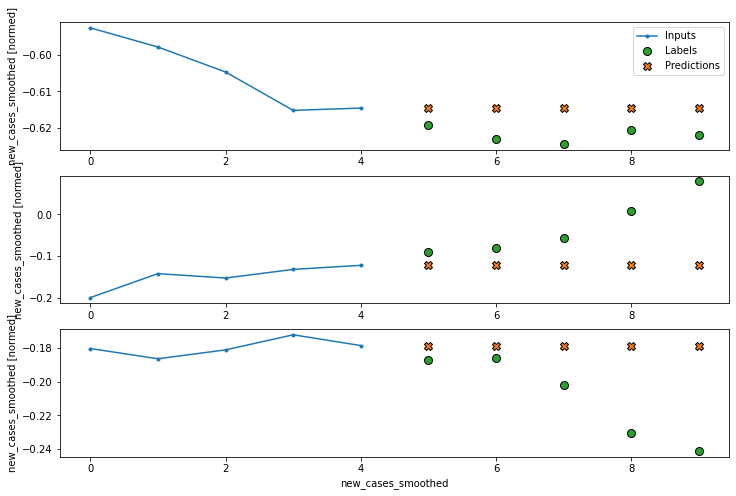

In [67]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


5/5 [==============================] - 0s 4ms/step - loss: 0.3015 - mean_absolute_error: 0.2456


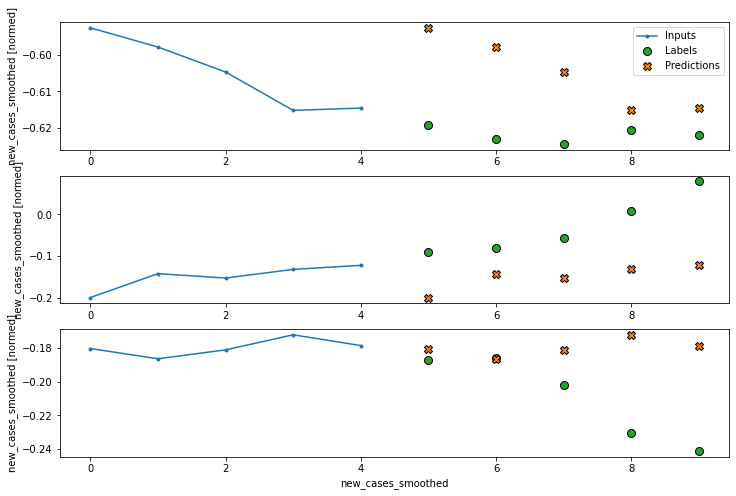

In [68]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


5/5 [==============================] - 0s 4ms/step - loss: 0.3015 - mean_absolute_error: 0.2456


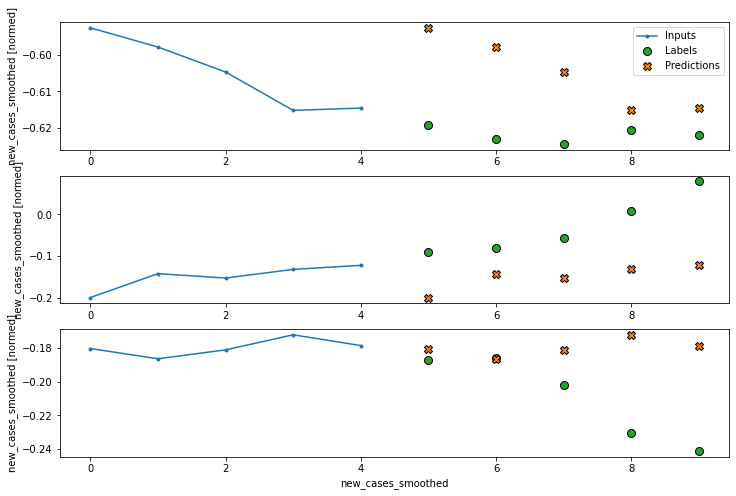

In [69]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


5/5 [==============================] - 0s 4ms/step - loss: 2.0473 - mean_absolute_error: 1.0361


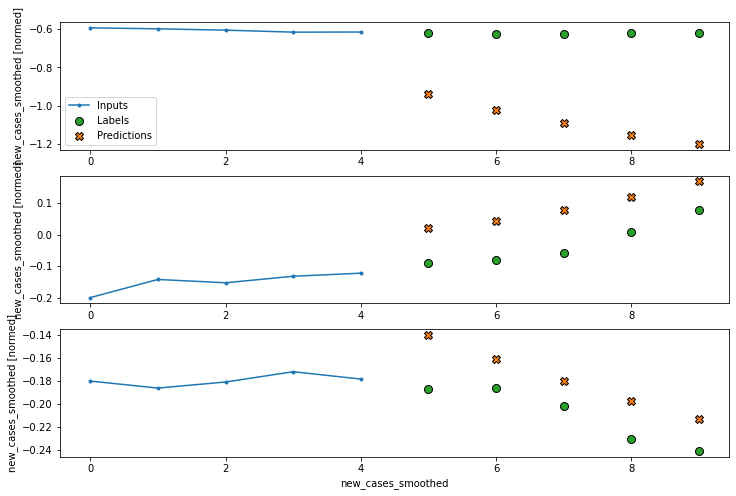

In [70]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


5/5 [==============================] - 0s 5ms/step - loss: 1.5518 - mean_absolute_error: 0.8417


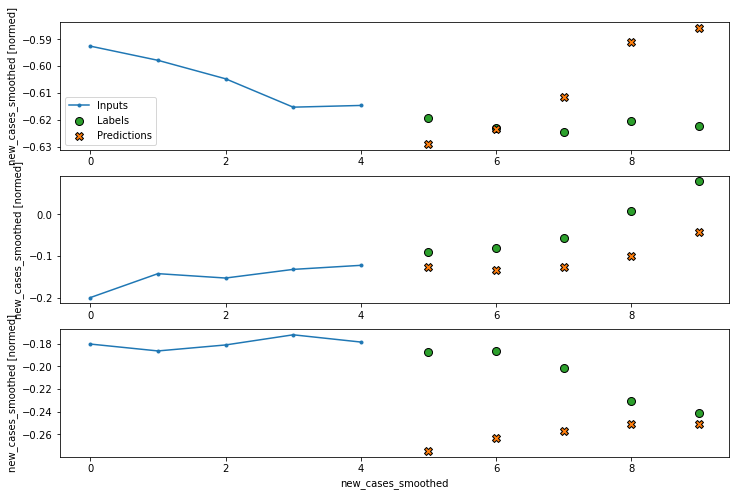

In [71]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)



5/5 [==============================] - 0s 4ms/step - loss: 1.4454 - mean_absolute_error: 0.8543


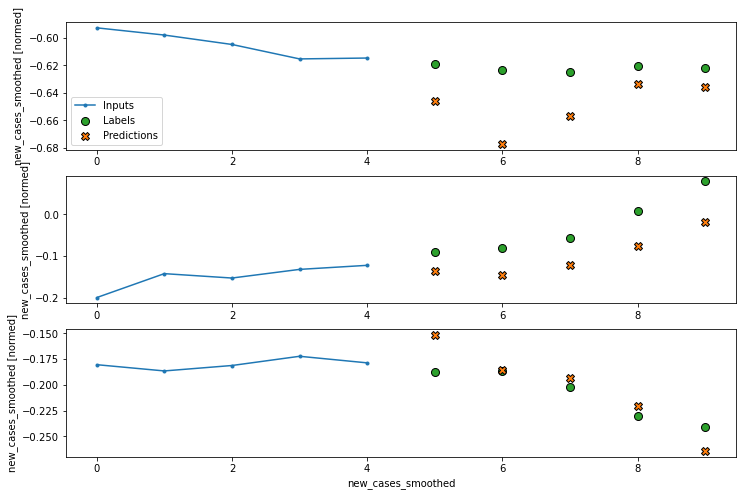

In [72]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


5/5 [==============================] - 0s 4ms/step - loss: 2.8701 - mean_absolute_error: 1.2447


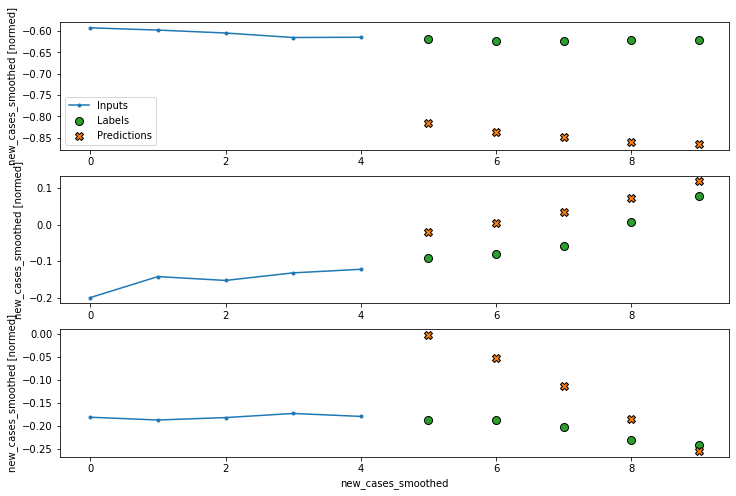

In [73]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [74]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


In [75]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [76]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


In [77]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape


TensorShape([32, 14])

In [78]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call


In [79]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 5, 14)


5/5 [==============================] - 0s 10ms/step - loss: 3.4857 - mean_absolute_error: 1.3953


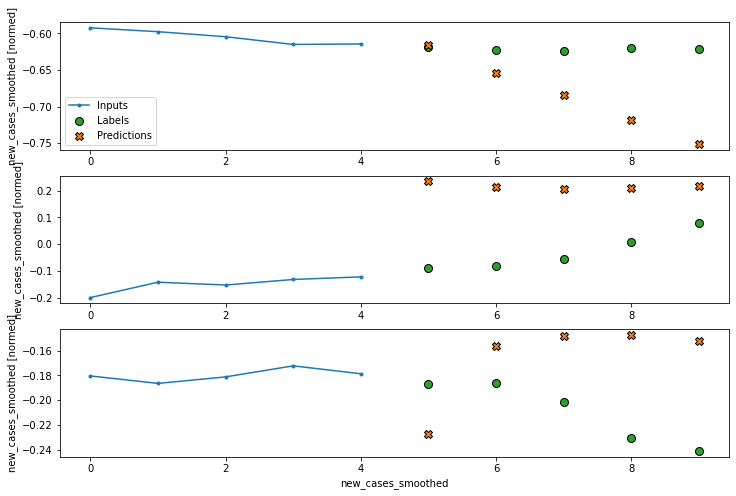

In [80]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)


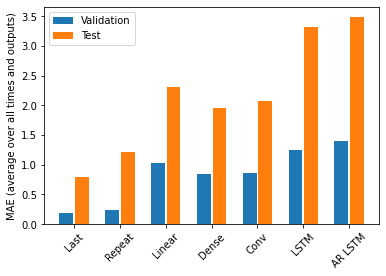

In [81]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


In [82]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')


Last    : 0.7916
Repeat  : 1.2149
Linear  : 2.3128
Dense   : 1.9529
Conv    : 2.0786
LSTM    : 3.3221
AR LSTM : 3.4831
